# Hand on 7.1

---
Page `22-27` of Handout #7

In [58]:
# Page 22 : (but optimized?)

import re
import string
from nltk.tokenize import word_tokenize
# Precompile regex patterns (compiled only once)
_var_addr_pattern = re.compile(r'.*0x[0-9a-f].*')
_name_with_number_pattern = re.compile(r'.*[a-f]*:[0-9]*')
_number_start_one_char_pattern = re.compile(r'[a-f][0-9].*')
_number_start_three_char_pattern = re.compile(r'[a-f]{3}[0-9].*')
_number_sub_pattern = re.compile(r'[\\/;:_-]')

def preprocess(text, stopword_set, stemmer):
    # Remove punctuation and unwanted characters, then lowercase the text
    translation_table = str.maketrans('', '', '!"#$%&\'()*+,.<=>?@[]^`{|}~' + u'\xa0')
    cleaned_text = text.translate(translation_table).lower()
    
    # Replace all whitespace characters with a single space
    cleaned_text = cleaned_text.translate(str.maketrans(string.whitespace, ' ' * len(string.whitespace), ''))
    
    # Split the text only once
    tokens = cleaned_text.split()
    new_tokens = []
    
    # Process each token with all transformation rules in one pass
    for token in tokens:
        if '_' in token:
            new_tokens.append('_variable_with_underscore')
        elif '-' in token:
            new_tokens.append('_variable_with_dash')
        elif len(token) > 15 and token[0] != '#':
            new_tokens.append('_long_variable_name')
        elif token.startswith('http') and '/' in token:
            new_tokens.append('_weburl')
        elif _number_sub_pattern.sub('', token).isdigit():
            new_tokens.append('_number')
        elif _var_addr_pattern.match(token):
            new_tokens.append('_variable_with_address')
        elif _name_with_number_pattern.match(token):
            new_tokens.append('_name_with_number')
        elif _number_start_one_char_pattern.match(token):
            new_tokens.append('_number_starts_with_one_character')
        elif _number_start_three_char_pattern.match(token):
            new_tokens.append('_number_starts_with_three_characters')
        elif any(c.isdigit() for c in token) and token.startswith('v'):
            new_tokens.append('_version')
        elif ('\\' in token or '/' in token) and ':' not in token:
            new_tokens.append('_localpath')
        elif token.endswith('px'):
            new_tokens.append('_image_size')
        else:
            new_tokens.append(token)
    
    # Remove stopwords and tokens shorter than 3 characters, then perform stemming
    final_tokens = [stemmer.stem(tok) for tok in new_tokens if tok not in stopword_set and len(tok) > 2]
    return ' '.join(final_tokens)



In [18]:
# Running this takes too long
# # Page 23
# import pandas as pd
# from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
# from multiprocessing import Pool
# 
# # Function to initialize global variables in worker processes
# def initialize_pool(stopword_set_arg, stemmer_arg):
#     global stopword_set, stemmer
#     stopword_set = stopword_set_arg
#     stemmer = stemmer_arg
# 
# # Load dataset
# dataset = pd.read_json('../Week 10/resource/embold_train.json')
# 
# # Label transformations
# dataset.loc[dataset['label'] > 0, 'label'] = -1
# dataset.loc[dataset['label'] == 0, 'label'] = 1
# dataset.loc[dataset['label'] == -1, 'label'] = 0
# 
# # Define stopwords and stemmer
# stopwords_set = set(stopwords.words('English'))
# ps = PorterStemmer()
# 
# # Initialize the pool of workers with the optimized preprocess globals
# pool = Pool(8, initializer=initialize_pool, initargs=(stopwords_set, ps))
# 
# # Preprocess the dataset using multiprocessing
# cleaned_title = pool.map(preprocess, dataset['title'])
# cleaned_body = pool.map(preprocess, dataset['body'])
# 
# 
# # Combine the cleaned texts into a DataFrame
# data_texts = pd.DataFrame({'title': cleaned_title, 'body': cleaned_body})
# 
# # Labels
# y = dataset['label']
# 
# # Close the pool
# pool.close()
# pool.join()

Pickle is now given, Skipping first 2 pages

In [19]:
# Skipping page 23
from nltk.corpus import stopwords
import pickle
from nltk.stem import PorterStemmer
from multiprocessing import Pool
# Read pickle
with open('../Week 10/resource/data_texts.pickle', 'rb') as f:
    data_texts = pickle.load(f)
with open('../Week 10/resource/embold_train_y.pickle', 'rb') as f:
    y = pickle.load(f)

In [20]:
# Page 25 : Walkthroughs – cross validation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import lightgbm as lgb
from sklearn import model_selection

# Split the dataset into training and blindtest (testing) sets
data_fit, data_blindtest, y_fit, y_blindtest = train_test_split(data_texts, y, test_size=0.1)

# Initialize the TF-IDF Vectorizer with unigrams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1))

# Concatenate the title and body columns
# Assuming 'data_texts' contains both 'title' and 'body' columns
data_texts_combined = data_texts['title'] + ' ' + data_texts['body']

# Fit the TF-IDF vectorizer on the concatenated text (title + body)
tfidf_vectorizer.fit(data_texts_combined)

# Transform the training and blindtest data
X_tfidf_fit = tfidf_vectorizer.transform(data_fit['title'] + ' ' + data_fit['body'])
X_tfidf_blindtest = tfidf_vectorizer.transform(data_blindtest['title'] + ' ' + data_blindtest['body'])

# Initialize the model
gbm_model = lgb.LGBMClassifier()

# Cross-validation for precision, recall, and f1 score
precision_cv_score = model_selection.cross_val_score(gbm_model, X_tfidf_fit, y_fit, cv=5, n_jobs=-2, scoring='precision_macro').mean()
recall_cv_score = model_selection.cross_val_score(gbm_model, X_tfidf_fit, y_fit, cv=5, n_jobs=-2, scoring='recall_macro').mean()
f1_cv_score = model_selection.cross_val_score(gbm_model, X_tfidf_fit, y_fit, cv=5, n_jobs=-2, scoring='f1_macro').mean()

# Output the results
print('CV: p:{0:.4f} r:{1:.4f} f:{2:.4f}'.format(precision_cv_score, recall_cv_score, f1_cv_score))




CV: p:0.7948 r:0.7922 f:0.7933


In [21]:
# Page 26 : Modelling
from sklearn import metrics

data_fit, data_blindtest, y_fit, y_blindtest = model_selection.train_test_split(data_texts, y, test_size=0.3)

data_fit_train, data_fit_test, y_fit_train, y_fit_test = model_selection.train_test_split(data_fit, y_fit, test_size=0.3)
X_tfidf_fit_train = tfidf_vectorizer.transform(data_fit_train['title'])
X_tfidf_fit_test = tfidf_vectorizer.transform(data_fit_test['title'])
X_tfidf_blindtest = tfidf_vectorizer.transform(data_blindtest['title'])

gbm_model.fit(X_tfidf_fit_train, y_fit_train, eval_set=[(X_tfidf_fit_test, y_fit_test)], eval_metric='AUC')

precision_test_score = metrics.precision_score(gbm_model.predict(X_tfidf_blindtest), y_blindtest, average='macro')
recall_test_score = metrics.recall_score(gbm_model.predict(X_tfidf_blindtest), y_blindtest, average='macro')
f1_test_score = metrics.f1_score(gbm_model.predict(X_tfidf_blindtest), y_blindtest, average='macro')

print('test: p:{0:.4f} r:{1:.4f} f:{2:.4f}'.format(precision_test_score, recall_test_score, f1_test_score))

[LightGBM] [Info] Number of positive: 32702, number of negative: 40798
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 84905
[LightGBM] [Info] Number of data points in the train set: 73500, number of used features: 1864
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444925 -> initscore=-0.221197
[LightGBM] [Info] Start training from score -0.221197
test: p:0.7396 r:0.7612 f:0.7424


In [22]:
import pickle

# Page 27 : Save the models
pickle.dump(tfidf_vectorizer, open('../Week 10/resource/github_bug_prediction_tfidf_vectorizer.pkl', 'wb'))
pickle.dump(gbm_model, open('../Week 10/resource/github_bug_prediction_basic_model.pkl', 'wb'))

---
Page `28-29` of Handout #7


In [23]:
from flask import Flask, request
from scipy.sparse import hstack
import pickle
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer  # Using PorterStemmer

# Initialize the Flask app
app = Flask(__name__)

# Load resources
app.tfidf_vectorizer = pickle.load(open('../Week 10/resource/github_bug_prediction_tfidf_vectorizer.pkl', 'rb'))
app.basic_model = pickle.load(open('../Week 10/resource/github_bug_prediction_basic_model.pkl', 'rb'))
app.stopword_set = set(stopwords.words('english'))
app.stemmer = PorterStemmer()  # Correctly initialize PorterStemmer

@app.route('/predict_basic', methods=['GET'])
def predict_basic_get():
    response_object = {'status': 'success'}
    
    # Get query parameters
    argList = request.args.to_dict(flat=False)
    title = argList.get('title', [None])[0]  # Safely get title
    body = argList.get('body', [None])[0]  # Safely get body

    if not title or not body:  # Validate input
        response_object['status'] = 'error'
        response_object['message'] = 'Missing title or body'
        return response_object

    # Apply preprocessing to the title
    processed_title = preprocess(title)  # Using preprocess function on the title

    # Predict bug likelihood
    predict = app.basic_model.predict_proba(hstack([app.tfidf_vectorizer.transform([processed_title])]))

    response_object['predict_as'] = 'bug' if predict[0][1] > 0.5 else 'not bug'
    response_object['bug_prob'] = predict[0][1]
    
    return response_object

@app.route('/predict_basic', methods=['POST'])
def predict_basic_post():
    response_object = {'status': 'success'}
    
    # Get data from JSON body
    data = request.get_json()  # Parse JSON body
    title = data.get('title')  
    body = data.get('body')    

    if not title or not body:  # Validate if title or body are missing
        response_object['status'] = 'error'
        response_object['message'] = 'Missing title or body'
        return response_object

    # Initialize stopword_set and stemmer
    stopword_set = set(stopwords.words('english'))  # Assuming you are using NLTK stopwords
    stemmer = PorterStemmer()  # Using PorterStemmer
    
    # Process title using preprocess with stopword_set and stemmer
    processed_title = preprocess(title, stopword_set, stemmer)

    # Predict bug likelihood
    predict = app.basic_model.predict_proba(hstack([app.tfidf_vectorizer.transform([processed_title])]))

    response_object['predict_as'] = 'bug' if predict[0][1] > 0.5 else 'not bug'
    response_object['bug_prob'] = predict[0][1]
    
    return response_object


In [24]:
# skip this today
# app.run(debug=False)

---
# Hand on 8.2
Page `39` of Handout #7

In [25]:
import pickle

# Page 27 : Save the models
pickle.dump(tfidf_vectorizer, open('../Week 10/resource/github_bug_prediction_tfidf_vectorizer.pkl', 'wb'))
pickle.dump(gbm_model, open('../Week 10/resource/github_bug_prediction_basic_model.pkl', 'wb'))

In [26]:
from sklearn.decomposition import TruncatedSVD
from sklearn import model_selection
import lightgbm as lgb
from scipy.sparse import hstack

lsa = TruncatedSVD(n_components=50, n_iter=100, random_state=0)
lsa.fit(X_tfidf_fit)
X_lsa_fit = lsa.transform(X_tfidf_fit)

gbm_model_with_lsa = lgb.LGBMClassifier()

In [27]:
X_lsa_fit = X_lsa_fit[:len(y_fit)]  # Trim X_lsa_fit to match the length of y_fit
X_tfidf_fit = X_tfidf_fit[:len(y_fit)]  # Trim X_tfidf_fit to match the length of y_fit

# Cross-validation using only LSA features
precision_cv_score = model_selection.cross_val_score(
    gbm_model_with_lsa, X_lsa_fit, y_fit, cv=5, n_jobs=-2, scoring='precision_macro'
).mean()

recall_cv_score = model_selection.cross_val_score(
    gbm_model_with_lsa, X_lsa_fit, y_fit, cv=5, n_jobs=-2, scoring='recall_macro'
).mean()

f1_cv_score = model_selection.cross_val_score(
    gbm_model_with_lsa, X_lsa_fit, y_fit, cv=5, n_jobs=-2, scoring='f1_macro'
).mean()

print('LSA fit: p:{0:.4f} r:{1:.4f} f:{2:.4f}'.format(precision_cv_score, recall_cv_score, f1_cv_score))


LSA fit: p:0.5010 r:0.5002 f:0.3959


In [28]:
# Stack LSA features with original features
X_fit_with_lsa = hstack([X_tfidf_fit, X_lsa_fit]).tocsr()

# Cross-validation using both LSA and original features
precision_cv_score = model_selection.cross_val_score(
    gbm_model_with_lsa, X_fit_with_lsa, y_fit, cv=5, n_jobs=-2, scoring='precision_macro'
).mean()

recall_cv_score = model_selection.cross_val_score(
    gbm_model_with_lsa, X_fit_with_lsa, y_fit, cv=5, n_jobs=-2, scoring='recall_macro'
).mean()

f1_cv_score = model_selection.cross_val_score(
    gbm_model_with_lsa, X_fit_with_lsa, y_fit, cv=5, n_jobs=-2, scoring='f1_macro'
).mean()

print('With LSA and original features: p:{0:.4f} r:{1:.4f} f:{2:.4f}'.format(precision_cv_score, recall_cv_score, f1_cv_score))

With LSA and original features: p:0.4994 r:0.4999 f:0.4042


---
Page `43` of handout 7

In [29]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import model_selection
import lightgbm as lgb
from scipy.sparse import hstack

# Load 'title' and 'body' columns
cleaned_title = data_texts['title']
cleaned_body = data_texts['body']

# Initialize and fit CountVectorizer
count_vectorizer = CountVectorizer(ngram_range=(1,1))
count_vectorizer.fit(cleaned_title + cleaned_body)

# Perform transformation
X_tf_fit = count_vectorizer.transform(data_fit['title'] + data_fit['body'])
X_tf_blindtest = count_vectorizer.transform(data_blindtest['title'] + data_blindtest['body'])

# Perform Latent Dirichlet Allocation (LDA)
lda = LatentDirichletAllocation(n_components=50, random_state=0)
lda.fit(X_tf_fit)
X_lda_fit = lda.transform(X_tf_fit)

# Initialize LightGBM classifier
gbm_model_with_lda = lgb.LGBMClassifier()

# Perform cross-validation with LDA-transformed data
precision_cv_score = model_selection.cross_val_score(
    gbm_model_with_lda, X_lda_fit, y_fit, cv=5, n_jobs=-2, scoring='precision_macro'
).mean()
recall_cv_score = model_selection.cross_val_score(
    gbm_model_with_lda, X_lda_fit, y_fit, cv=5, n_jobs=-2, scoring='recall_macro'
).mean()
f1_cv_score = model_selection.cross_val_score(
    gbm_model_with_lda, X_lda_fit, y_fit, cv=5, n_jobs=-2, scoring='f1_macro'
).mean()

print('fit: p:{0:.4f} r:{1:.4f} f:{2:.4f}'.format(precision_cv_score, recall_cv_score, f1_cv_score))

# Combine original TF-IDF features with LDA-transformed features
X_fit_with_lda = hstack([X_tfidf_fit, X_lda_fit]).tocsr()

# Perform cross-validation with combined features
precision_cv_score = model_selection.cross_val_score(
    gbm_model_with_lda, X_fit_with_lda, y_fit, cv=5, n_jobs=-2, scoring='precision_macro'
).mean()
recall_cv_score = model_selection.cross_val_score(
    gbm_model_with_lda, X_fit_with_lda, y_fit, cv=5, n_jobs=-2, scoring='recall_macro'
).mean()
f1_cv_score = model_selection.cross_val_score(
    gbm_model_with_lda, X_fit_with_lda, y_fit, cv=5, n_jobs=-2, scoring='f1_macro'
).mean()

print('fit: p:{0:.4f} r:{1:.4f} f:{2:.4f}'.format(precision_cv_score, recall_cv_score, f1_cv_score))


fit: p:0.6819 r:0.6745 f:0.6756
fit: p:0.6802 r:0.6726 f:0.6736


---
Page `45` of Handout 7

In class activity
- Make a TF-IDF + LSA + LDA version
- Please carefully design the dataflow
- Raw data -> TF-IDF vectorizer -> basic … (1)
- Raw data -> TF-IDF vectorizer -> LSA … (2)
- Raw data -> TF vectorizer -> LDA … (3)
- GBM( 1 + 2 + 3 ) -> predicted probability
- Make this TF-IDF + LSA + LDA a flask application

Firstly we build the Basic & LSA Pipelines

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

# Assume data_texts is a DataFrame with 'title' and 'body' columns and y are the labels.
# Combine title and body
data_texts_combined = data_texts['title'] + ' ' + data_texts['body']

# Pipeline (1): TF-IDF representation
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1))
X_tfidf = tfidf_vectorizer.fit_transform(data_texts_combined)

# Pipeline (2): LSA on TF-IDF features
# We use TruncatedSVD to reduce dimensionality (i.e. perform LSA)
lsa = TruncatedSVD(n_components=50, n_iter=100, random_state=0)
# Fit LSA on the TF-IDF matrix and transform it:
X_lsa = lsa.fit_transform(X_tfidf)  # This gives a dense matrix

# Convert LSA output to a sparse format so it can be hstacked with X_tfidf:
X_lsa_sparse = csr_matrix(X_lsa)

# At this point, pipelines (1) and (2) are built.

The we build the TF + LDA Pipeline

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Pipeline (3): Use a CountVectorizer (TF) for raw counts
count_vectorizer = CountVectorizer(ngram_range=(1,1))
X_tf = count_vectorizer.fit_transform(data_texts_combined)

# Apply LDA on the count matrix to extract topics
lda = LatentDirichletAllocation(n_components=50, random_state=0)
# Fit LDA and transform the count matrix:
X_lda = lda.fit_transform(X_tf)  # This is dense (each row = topic distribution)

# Convert LDA output to sparse format for stacking:
X_lda_sparse = csr_matrix(X_lda)

Combine Features and Train the Combined GBM Model

In [32]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.sparse import hstack

# Combine features from all three pipelines: (1) TF-IDF (basic), (2) LSA features, (3) LDA topic distribution
X_combined = hstack([X_tfidf, X_lsa_sparse, X_lda_sparse]).tocsr()

# Optionally, ensure X_combined and y have matching dimensions (e.g., slicing if needed)
X_combined = X_combined[:len(y)]

# Train/test split for evaluation (or cross-validation)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42)

# Train a LightGBM model on the combined features:
gbm_combined = LGBMClassifier(n_jobs=-1, random_state=42)
gbm_combined.fit(X_train, y_train)

# Evaluate using cross-validation (example: F1 macro score)
cv_score = cross_val_score(gbm_combined, X_combined, y, cv=5, scoring='f1_macro').mean()
print("Combined model cross-validation F1 score:", cv_score)


[LightGBM] [Info] Number of positive: 46826, number of negative: 58174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.566523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 392077
[LightGBM] [Info] Number of data points in the train set: 105000, number of used features: 5344
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445962 -> initscore=-0.217000
[LightGBM] [Info] Start training from score -0.217000
[LightGBM] [Info] Number of positive: 53462, number of negative: 66538
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.541366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 421845
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 5752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445517 -> initscore=-0.218802
[LightGBM] [Info] Start training from score -0.218802
[L

 Save the Trained Components

In [33]:
import pickle

pickle.dump(tfidf_vectorizer, open('tfidf_vectorizer.pkl', 'wb'))
pickle.dump(lsa, open('lsa.pkl', 'wb'))
pickle.dump(count_vectorizer, open('count_vectorizer.pkl', 'wb'))
pickle.dump(lda, open('lda.pkl', 'wb'))
pickle.dump(gbm_combined, open('gbm_combined.pkl', 'wb'))


Now we can make Flask application for it

In [72]:
from flask import Flask, request, jsonify
from scipy.sparse import hstack, csr_matrix
import pickle

app = Flask(__name__)

# Load pre-trained components
tfidf_vectorizer = pickle.load(open('tfidf_vectorizer.pkl', 'rb'))
lsa = pickle.load(open('lsa.pkl', 'rb'))
count_vectorizer = pickle.load(open('count_vectorizer.pkl', 'rb'))
lda = pickle.load(open('lda.pkl', 'rb'))
gbm_combined = pickle.load(open('gbm_combined.pkl', 'rb'))

@app.route('/predict/combined', methods=['POST'])
def predict_combined():
    """ Handle POST request with JSON input and return prediction in structured format. """
    data = request.get_json()

    if not data or ('title' not in data and 'body' not in data):
        return jsonify({'status': 'error', 'message': 'No title or body provided'}), 400

    title = data.get('title', '')  # Default to empty string if missing
    body = data.get('body', '')

    raw_text = f"{title} {body}".strip()

    if not raw_text:
        return jsonify({'status': 'error', 'message': 'Title and body are empty'}), 400

    # Transform input text
    X_tfidf_input = tfidf_vectorizer.transform([raw_text])
    X_lsa_input = lsa.transform(X_tfidf_input)
    X_lsa_input_sparse = csr_matrix(X_lsa_input)
    X_tf_input = count_vectorizer.transform([raw_text])
    X_lda_input = lda.transform(X_tf_input)
    X_lda_input_sparse = csr_matrix(X_lda_input)

    # Combine representations
    X_combined_input = hstack([X_tfidf_input, X_lsa_input_sparse, X_lda_input_sparse]).tocsr()

    # Predict probability
    predicted_probability = gbm_combined.predict_proba(X_combined_input)[0]
    bug_prob = predicted_probability[1]  # Assuming index 1 is for "bug"

    return jsonify({
        'status': 'success',
        'predict_as': 'bug' if bug_prob > 0.5 else 'not bug',
        'bug_prob': bug_prob
    })


In [ ]:
# Run application here
app.run(debug=False)

Result:

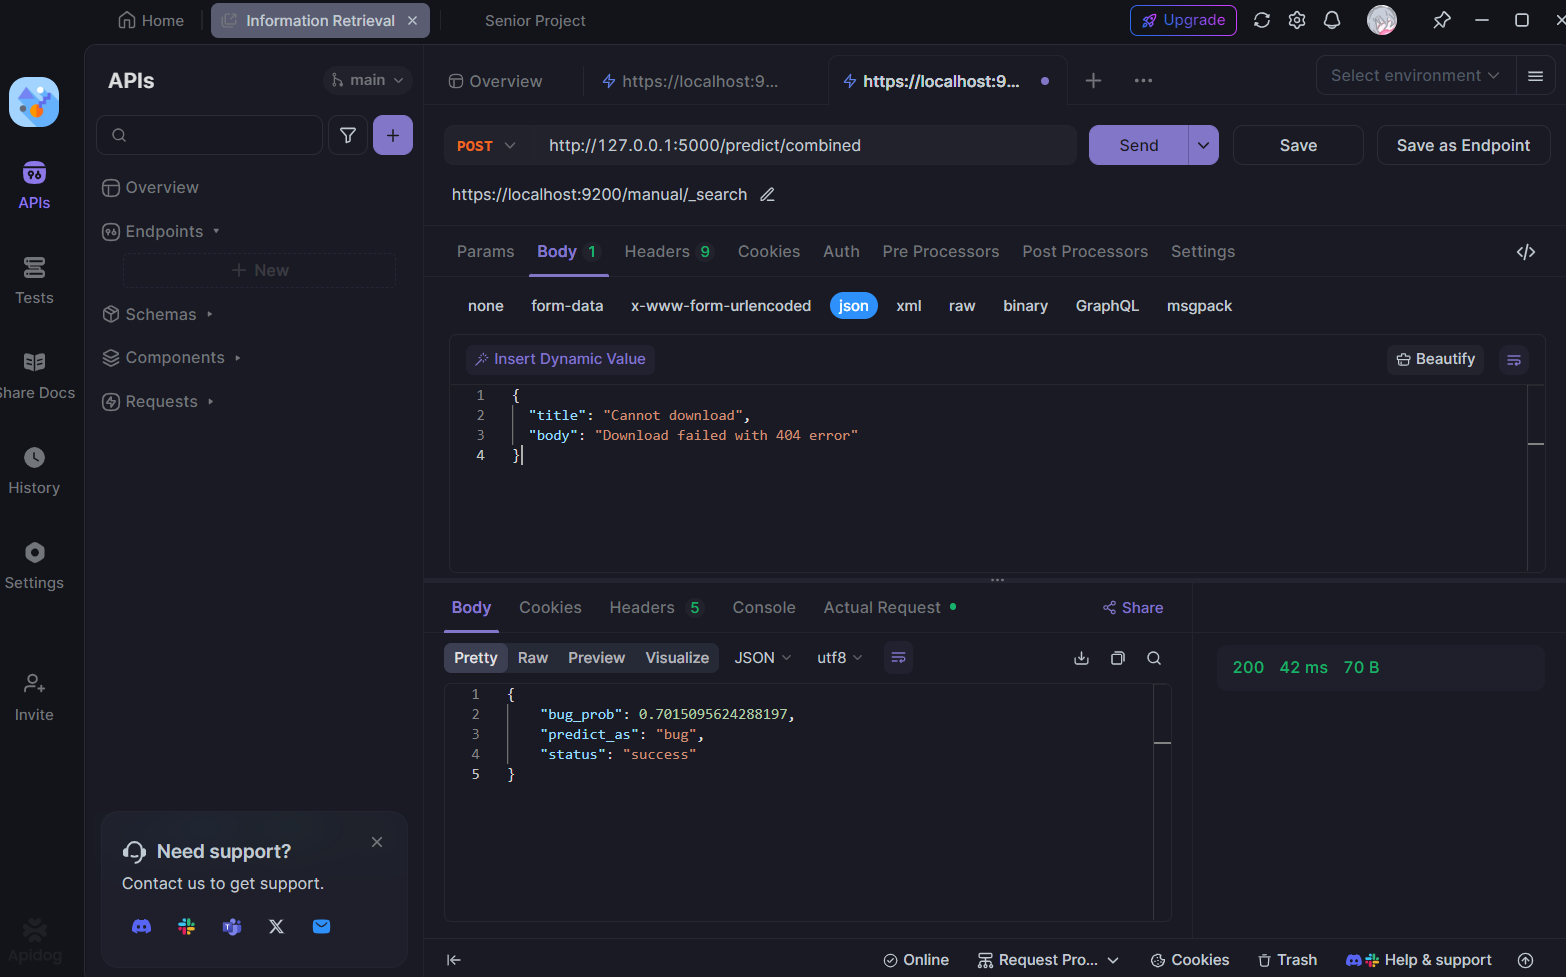

---
# Hand on 8.3

```
Page 50-51 of Handout #7
Page 53 of Handout #7
Page 60-67 of Handout #7
```

In [35]:
# Optuna : Page 50
import optuna
import lightgbm as lgb
import numpy as np
from sklearn import metrics

def objective(trial):
    dtrain = lgb.Dataset(X_tfidf_fit_train, label=y_fit_train)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_tfidf_fit_test)
    pred_labels = np.rint(preds)
    accuracy = metrics.roc_auc_score(y_fit_test, pred_labels)
    
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
trial = study.best_trial


[I 2025-03-03 15:43:54,119] A new study created in memory with name: no-name-c2bd781b-ca9d-4d71-9e94-1c9f652a035f
[I 2025-03-03 15:43:59,343] Trial 0 finished with value: 0.7587089657848682 and parameters: {'lambda_l1': 0.36016001734493297, 'lambda_l2': 0.06427575954231793, 'num_leaves': 107, 'feature_fraction': 0.847366688163351, 'bagging_fraction': 0.9054892003713819, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 0 with value: 0.7587089657848682.
[I 2025-03-03 15:44:03,037] Trial 1 finished with value: 0.7384125286012682 and parameters: {'lambda_l1': 6.124763303931028e-05, 'lambda_l2': 1.2147166164077154, 'num_leaves': 176, 'feature_fraction': 0.5564562931288485, 'bagging_fraction': 0.6252624851552053, 'bagging_freq': 5, 'min_child_samples': 89}. Best is trial 0 with value: 0.7587089657848682.
[I 2025-03-03 15:44:06,484] Trial 2 finished with value: 0.7562482453014331 and parameters: {'lambda_l1': 1.9243777776494233e-07, 'lambda_l2': 5.903205884402608e-06, 'num_leaves': 

In [36]:
# Page 51
gbm_model = lgb.LGBMClassifier(**trial.params)

precision_cv_score = model_selection.cross_val_score(
    gbm_model, X_tfidf_fit, y_fit, cv=5, n_jobs=-2, scoring="precision_macro"
).mean()

recall_cv_score = model_selection.cross_val_score(
    gbm_model, X_tfidf_fit, y_fit, cv=5, n_jobs=-2, scoring="recall_macro"
).mean()

f1_cv_score = model_selection.cross_val_score(
    gbm_model, X_tfidf_fit, y_fit, cv=5, n_jobs=-2, scoring="f1_macro"
).mean()

print(f"CV: p:{precision_cv_score:.4f} r:{recall_cv_score:.4f} f:{f1_cv_score:.4f}")

gbm_model.fit(
    X_tfidf_fit_train, y_fit_train, 
    eval_set=[(X_tfidf_fit_test, y_fit_test)], 
    eval_metric="AUC"
)

precision_test_score = metrics.precision_score(
    gbm_model.predict(X_tfidf_blindtest), y_blindtest, average="macro"
)

recall_test_score = metrics.recall_score(
    gbm_model.predict(X_tfidf_blindtest), y_blindtest, average="macro"
)

f1_test_score = metrics.f1_score(
    gbm_model.predict(X_tfidf_blindtest), y_blindtest, average="macro"
)

print(f"test: p:{precision_test_score:.4f} r:{recall_test_score:.4f} f:{f1_test_score:.4f}")



CV: p:0.5057 r:0.5034 f:0.4631
test: p:0.7546 r:0.7641 f:0.7570


In [39]:
# Save the model
import pickle

with open("gbm_model.pkl", "wb") as f:
    pickle.dump(gbm_model, f)

Page 53: made into flask app

In [73]:
from flask import Flask, request, jsonify
from scipy.sparse import hstack, csr_matrix
import pickle

app = Flask(__name__)

# Load pre-trained components into the app context
with open('tfidf_vectorizer.pkl', 'rb') as f:
    app.tfidf_vectorizer = pickle.load(f)
with open('lsa.pkl', 'rb') as f:
    app.lsa_model = pickle.load(f)
with open('count_vectorizer.pkl', 'rb') as f:
    app.count_vectorizer = pickle.load(f)
with open('lda.pkl', 'rb') as f:
    app.lda_model = pickle.load(f)
with open('gbm_model.pkl', 'rb') as f:
    app.optimized_model = pickle.load(f)
@app.route('/predict_optimized_tfidf_lda', methods=['POST'])
def predict_optimized_tfidf_lda():
    # Parse JSON from the request body
    data = request.get_json()
    if not data or 'title' not in data:
        return jsonify({'status': 'error', 'message': 'Missing required parameter: title'}), 400

    title = data['title']
    
    try:
        # Transform the input text using vectorizers and models
        tfidf_data = app.tfidf_vectorizer.transform([preprocess(title)])
        lsa_data = app.lsa_model.transform(tfidf_data)
        lda_data = app.lda_model.transform(app.count_vectorizer.transform([preprocess(title)]))
        
        # Combine features from TF-IDF, LSA, and LDA
        query_data = hstack([tfidf_data, csr_matrix(lsa_data), csr_matrix(lda_data)]).tocsr()

        # Check the number of features and chop off extra features if necessary
        expected_features = app.optimized_model.n_features_in_  # Get the expected number of features from the model
        if query_data.shape[1] > expected_features:
            query_data = query_data[:, :expected_features]  # Slice the data to match the expected number of features

        # Predict probabilities using the optimized model
        preds = app.optimized_model.predict_proba(query_data)
        bug_prob = preds[:, 1][0]  # Assuming the positive class is at index 1

        return jsonify({
            'status': 'success',
            'predict_as': 'bug' if bug_prob > 0.5 else 'not bug',
            'bug_prob': bug_prob
        })
    except Exception as e:
        # If there is an error in the process, return the error message
        return jsonify({'status': 'error', 'message': str(e)}), 500


In [71]:
app.run(debug=False)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [03/Mar/2025 16:20:14] "POST /predict_optimized_tfidf_lda HTTP/1.1" 200 -


Page 60-67 - Learning to rank

In [89]:
# Page 60
import pandas as pd
anime = pd.read_csv('resource/anime.csv')
rating = pd.read_csv('resource/anime_rating_1000_users.csv')
anime_features = ['MAL_ID','English name','Japanese name','Score','Genres','Popularity',
    'Members','Favorites','Watching','Completed','On-Hold','Dropped',
    'Score-1','Score-2','Score-3','Score-4','Score-5',
    'Score-6','Score-7','Score-8','Score-9','Score-10',
]
anime = anime[anime_features]

merged_df = anime.merge(rating, left_on='MAL_ID', right_on='anime_id', how='inner')

genre_names = [
    'Action', 'Adventure','Comedy', 'Drama','Sci-Fi', 'Game', 'Space', 'Music', 'Mystery',
    'School', 'Fantasy', 'Horror', 'Kids', 'Sports', 'Magic', 'Romance'
]

In [90]:
# Page 61
def genre_to_category(df):
    d = {name :[] for name in genre_names}

    def f(row):
        genres = [s.strip() for s in row.Genres.split(',')]
        for genre in genre_names:
            if genre in genres:
                d[genre].append(1)
            else:
                d[genre].append(0)

    df.apply(f, axis=1)

    genre_df = pd.DataFrame(d, columns=genre_names)
    df = pd.concat([df, genre_df], axis=1)
    return df

def make_anime_feature(df):
    df['Score'] = df['Score'].apply(lambda x: np.nan if x=='Unknown' else float(x))
    for i in range(1, 11):
        df[f'Score-{i}'] = df[f'Score-{i}'].apply(lambda x: np.nan if x=='Unknown' else float(x))

    df = genre_to_category(df)

    return df

In [ ]:
# Page 62
def make_user_feature(df):
    df['rating_count'] = df.groupby('user_id')['anime_id'].transform('count')
    df['rating_mean'] = df.groupby('user_id')['rating'].transform('mean')
    df['rating_std'] = df.groupby('user_id')['rating'].transform('std')
    return df

def preprocess(merged_df):
    merged_df = make_anime_feature(merged_df)
    merged_df = make_user_feature(merged_df)
    return merged_df

merged_df = preprocess(merged_df)
merged_df = merged_df.drop(['MAL_ID', 'Genres'], axis=1)


In [92]:
# Page 63
fit, blindtest = train_test_split(merged_df, test_size=0.2, random_state=0)
fit_train, fit_test = train_test_split(fit, test_size=0.3, random_state=0)

features = ['Score', 'Popularity','Members',
    'Favorites','Watching','Completed','On-Hold','Dropped',
    'Score-1','Score-2','Score-3','Score-4','Score-5',
    'Score-6','Score-7','Score-8','Score-9','Score-10',
    'rating_count','rating_mean'
]
features += genre_names
user_col = 'user_id'
item_col = 'anime_id'
target_col = 'rating'

fit_train = fit_train.sort_values('user_id').reset_index(drop=True)
fit_test = fit_test.sort_values('user_id').reset_index(drop=True)
blindtest = blindtest.sort_values('user_id').reset_index(drop=True)

fit_train_query = fit_train[user_col].value_counts().sort_index()
fit_test_query = fit_test[user_col].value_counts().sort_index()
blindtest_query = blindtest[user_col].value_counts().sort_index()


In [96]:
# Page 64
model = lgb.LGBMRanker(n_estimators=1000, random_state=0)
model.fit(
    fit_train[features],
    fit_train[target_col],
    group=fit_train_query,
    eval_set=[(fit_test[features], fit_test[target_col])],
    eval_group=[list(fit_test_query)],
    eval_at=[1, 3, 5, 10],  # calc validation ndcg@1,3,5,10
)

model.predict(blindtest.iloc[:10][features])

array([-0.38306432,  0.47909498, -0.42277161, -1.73095109, -1.91449705,
       -5.41850329, -4.91614957, -0.96555131, -0.42521591, -1.86715732])

Text(0.5, 1.0, 'feature importance')

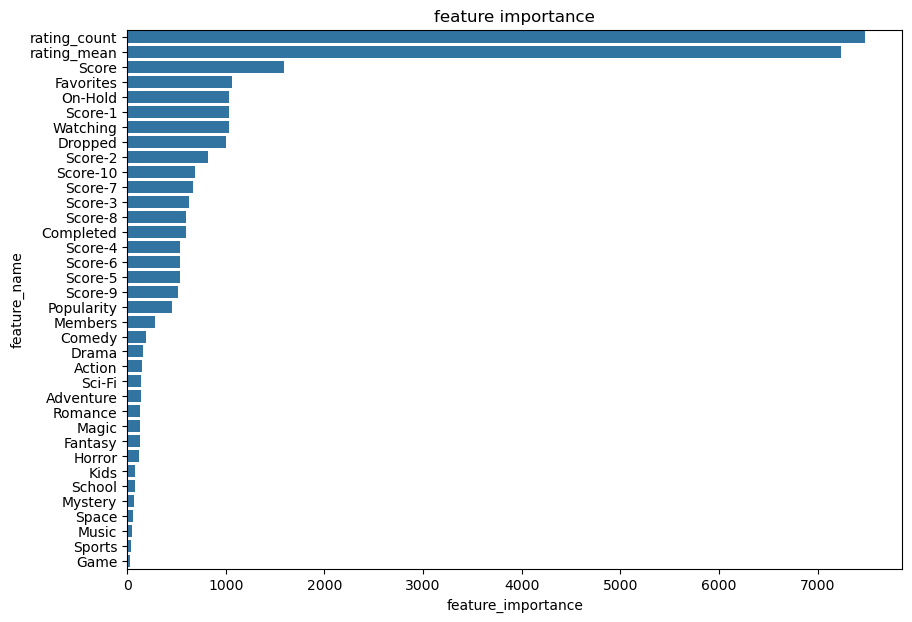

In [98]:
# Page 65
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 7))
df_plt = pd.DataFrame({'feature_name': features, 'feature_importance': model.feature_importances_})
df_plt.sort_values('feature_importance', ascending=False, inplace=True)
sns.barplot(x="feature_importance", y="feature_name", data=df_plt)
plt.title('feature importance')


In [99]:
# Page 66
def predict(user_df, top_k, anime, rating):
    user_anime_df = anime.merge(user_df, left_on='MAL_ID', right_on='anime_id')
    user_anime_df = make_anime_feature(user_anime_df)

    excludes_genres = list(np.array(genre_names)[np.nonzero([user_anime_df[genre_names].sum(axis=0) <= 1])[1]])

    pred_df = make_anime_feature(anime.copy())
    pred_df = pred_df.loc[pred_df[excludes_genres].sum(axis=1)==0]

    for col in user_df.columns:
        if col in features:
            pred_df[col] = user_df[col].values[0]

    preds = model.predict(pred_df[features])

    topk_idx = np.argsort(preds)[::-1][:top_k]

    recommend_df = pred_df.iloc[topk_idx].reset_index(drop=True)

    print('---------- Recommend ----------')
    for i, row in recommend_df.iterrows():
        print(f'{i+1}: {row["Japanese name"]}:{row["English name"]}')

    print('---------- Rated ----------')
    user_df = user_df.merge(anime, left_on='anime_id', right_on='MAL_ID', how='inner')
    for i, row in user_df.sort_values('rating',ascending=False).iterrows():
        print(f'rating:{row["rating"]}: {row["Japanese name"]}:{row["English name"]}')

    return recommend_df



In [100]:
user_df = rating.copy().loc[rating['user_id'] == user_id]
user_df = make_user_feature(user_df)
predict(user_df, 10, anime, rating)

NameError: name 'user_id' is not defined